In [1]:
import satlaspretrain_models
import torch
import pytorch_warmup as warmup


weights_manager = satlaspretrain_models.Weights()


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np


class SSEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.spatial_se = nn.Conv2d(channel, 1, kernel_size=1,
                                    stride=1, padding=0)

    def forward(self, x):
        spa_se = torch.sigmoid(self.spatial_se(x))
        spa_se = torch.mul(x, spa_se)
        return spa_se

class UNetUpBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(mode='bilinear', scale_factor=2)
        self.conv = torch.nn.Conv2d(in_channels, out_channels, 3, stride = 1, padding=1, bias = False)
        self.relu = torch.nn.ReLU()
        self.gn = torch.nn.GroupNorm(out_channels // 8, out_channels)
        self.sse = SSEBlock(out_channels)

    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        x = self.relu(x)
        x = self.gn(x)
        x = self.sse(x)
        return x

class UNetDownBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, f, norm = True):
        super(UNetDownBlock, self).__init__()
        self.norm = norm
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.relu = torch.nn.ReLU()
        if self.norm:
            self.gn = torch.nn.GroupNorm(out_channels // 8, out_channels)
        self.sse = SSEBlock(out_channels)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        if self.norm:
            x = self.gn(x)
        x = self.sse(x)
        return x

class UNetEncoder(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.downblock10to20 = UNetDownBlock(36, 64, 2, norm = True)
        self.maxPool1 = torch.nn.MaxPool2d(2, 2)
        self.downblock20to40 = UNetDownBlock(64, 128, 2)
        self.maxPool2 = torch.nn.MaxPool2d(2, 2)
        #self.downblock40to80 = UNetDownBlock(64, 128, 2)
        #self.maxPool3 = torch.nn.MaxPool2d(2)
        self.forwardblock = UNetDownBlock(128, 128, 1)
    
    def forward(self, x):
        tenm = self.downblock10to20(x)
        twentym = self.maxPool1(tenm)
        twentym = self.downblock20to40(twentym)
         
        fourtym = self.maxPool2(twentym)
        fourtym = self.forwardblock(fourtym)

        #eightym = self.maxPool3(fourtym)
        #eightym = self.forwardblock(eightym)
        return [tenm, twentym, fourtym]
         
         
class SupHead(torch.nn.Module):
    def __init__(self, backbone_channels, num_categories=2):
        super(SupHead, self).__init__()
        use_channels = backbone_channels
        num_layers = 2
        self.num_outputs = 2

        self.upblock1 = UNetUpBlock(128 + 128, 128)
        self.upblock2 = UNetUpBlock(128 + 128, 128)

        self.out_conv1 = torch.nn.Conv2d(128+64, 96, 1)
        self.relu1 = torch.nn.ReLU()
        self.out_conv = torch.nn.Conv2d(96, 2, 1)

        self.loss_func = lambda logits, targets: torch.nn.functional.cross_entropy(logits, targets, reduction='none')
        
    def forward(self, image_list, raw_features, encoded, targets=None):

        unet_encode0 = encoded[0] # 10m
        unet_encode1 = encoded[-2] # 28 x 28
        unet_encode2 = encoded[-1] # 14 x 14
        swin_encode2 = raw_features[0] # 14 x 14
        #swin_encode1 = raw_features[1] # 7 x 7

        encode1 = torch.cat((unet_encode2, swin_encode2), 1)
        up1 = self.upblock1(encode1)
        up2 = self.upblock2(torch.concat((up1, unet_encode1), 1))
        up2 = torch.concat((up2, unet_encode0), 1)
        up2 = self.relu1(self.out_conv1(up2))
        
        raw_outputs = self.out_conv(up2)
        
        #raw_outputs = self.layers(raw_features[0])
        loss = None

        outputs = torch.nn.functional.softmax(raw_outputs, dim=1)

        if targets is not None:
            task_targets = torch.stack([target for target in targets], dim=0).long()
            #loss = self.loss_func(raw_outputs, task_targets)
            loss = self.loss_func(raw_outputs[:, :, 21:21+14, 21:21+14], task_targets)
            loss = loss.mean()


        return outputs, loss

model = weights_manager.get_pretrained_model(model_identifier="Sentinel2_SwinB_MI_MS",
                                             fpn=True,
                                             head = SupHead(128),
                                             encoder = UNetEncoder(32),
                                             #head=satlaspretrain_models.utils.Head.SEGMENT,
                                             num_categories = 2)#Head(128), num_categories=2)

In [3]:
model.head

SupHead(
  (upblock1): UNetUpBlock(
    (upsample): Upsample(scale_factor=2.0, mode='bilinear')
    (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (relu): ReLU()
    (gn): GroupNorm(16, 128, eps=1e-05, affine=True)
    (sse): SSEBlock(
      (spatial_se): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (upblock2): UNetUpBlock(
    (upsample): Upsample(scale_factor=2.0, mode='bilinear')
    (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (relu): ReLU()
    (gn): GroupNorm(16, 128, eps=1e-05, affine=True)
    (sse): SSEBlock(
      (spatial_se): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (out_conv1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
  (relu1): ReLU()
  (out_conv): Conv2d(96, 2, kernel_size=(1, 1), stride=(1, 1))
)

In [85]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

89631943


In [5]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
class Dataset(Dataset):
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        # Create a mapping from class label to a unique integer.        
        self.datapoints = os.listdir(self.dataset_path + 'input/')
        self.datapoints = [x for x in self.datapoints if x[-4:] == '.npy']

    def __getitem__(self, idx):
        img_path = os.path.join(self.dataset_path, 'input/')
        target_path = os.path.join(self.dataset_path, 'target/')
        input = np.load(img_path + self.datapoints[idx]).astype(np.float32) / 65535
        input = input[:, 1:-1, 1:-1, :]
        b2 = np.copy(input[..., 2])
        input[..., 2] = input[..., 0]
        input[..., 0] = b2
        input = np.moveaxis(input, -1, 1)
        input = np.reshape(input, (4*9, 56, 56))
        output = np.load(target_path + self.datapoints[idx]).astype(np.float32)
        output = np.clip(output, 0, 1)
        #output = np.pad(output, ((22, 22), (22, 22)), mode = 'constant')
        return input, output

    def __len__(self):
        return len(self.datapoints)

TTCData = Dataset('/Volumes/Macintosh HD/Users/work/Documents/ttc-training-data/')
train_dataloader = DataLoader(
    TTCData,
    batch_size=16,
    shuffle=True,
    num_workers=0
)

In [6]:
model = model.to('mps')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_steps = len(train_dataloader) * 20
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)


In [ ]:
for epoch in range(1, 50):
    print("Starting Epoch...", epoch)
    batch_count = 0
    for data, target in train_dataloader:
        #print(target.shape)
        data = data.to('mps')
        target = target.to('mps')

        output, loss = model(data, target)
        if batch_count % 50 == 0:
            print(f"{batch_count}, Train Loss = {loss}")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        with warmup_scheduler.dampening():
            lr_scheduler.step()
        batch_count += 1

Starting Epoch... 1
0, Train Loss = 0.25073596835136414
50, Train Loss = 0.33367010951042175
100, Train Loss = 0.3298594355583191
150, Train Loss = 0.4148126244544983
200, Train Loss = 0.4473152458667755
250, Train Loss = 0.3868022859096527
300, Train Loss = 0.4743344783782959
350, Train Loss = 0.2942418158054352


# Inference

In [93]:
import hickle as hkl
import seaborn as sns
x = hkl.load('../src/1637X1088Y.hkl')
#x = hkl.load('../src/2283X714Y.hkl')
x = x[:, 1:-1, 1:-1, :]
#x = x[:, 1:-1, :, :]
print(x.shape)


(12, 616, 612, 17)


In [94]:
x = np.reshape(x, (4, 3, x.shape[1], x.shape[2], x.shape[3]))
x = np.median(x, axis = 1, overwrite_input = True)
b2 = np.copy(x[..., 2])
x[..., 2] = x[..., 0]
x[..., 0] = b2
x = x[..., :10]
x = np.delete(x, 3, -1)
x = np.moveaxis(x, -1, 1)
x = np.reshape(x, (4*9, x.shape[-2], x.shape[-1]))
print(x.shape)

(36, 616, 612)


In [95]:
with torch.no_grad():
    out = model(torch.tensor(x[np.newaxis]).to('mps'))
    #print(x[0].shape)

In [96]:
out[0].cpu().detach().numpy().squeeze()[1].shape

(616, 612)

<Axes: >

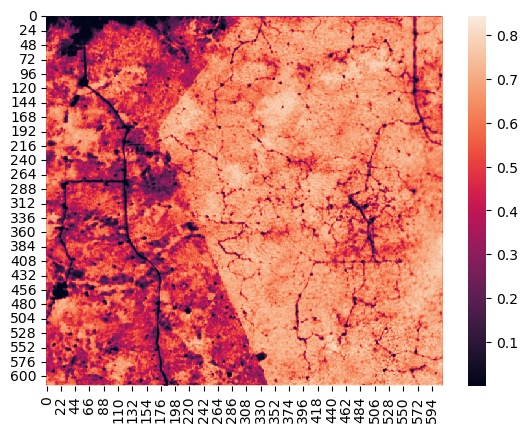

In [97]:
sns.heatmap(out[0].cpu().detach().numpy().squeeze()[1])

# Make the training data

In [ ]:
import os
import hickle as hkl
import numpy as np
import rasterio as rs
fpath = '/Volumes/John/train-ard-128/'
ypath = '/Volumes/John/data/train-17k-may2023/train-y/'
output_xpath = '/Volumes/Macintosh HD/Users/work/Documents/ttc-training-data/input/'
output_ypath = '/Volumes/Macintosh HD/Users/work/Documents/ttc-training-data/target/'
x_files = [x[:-4] for x in os.listdir(fpath) if x[-4:] == '.hkl']
train_bad = [x[:-4] for x in os.listdir('/Volumes/John/data/train-17k-may2023/bad/')]
x_files = [x for x in x_files  if x not in train_bad]

In [ ]:
# TCI (this is three channels, RGB; divide by 255)
# B05, B06, B07, B08, B11, B12 (divide by 8160, clip to 0-1)
# TTC is 4 3 2 8a 5 6 7 8 11 12
# SAT is 4 3 2 5 6 7 8 11 12
# 0, 1, 2, 4, 5, 6, 7, 

def write_output(fpath, ypath, f):
    ishkl = os.path.exists(fpath + f + '.hkl')
    if ishkl:
        out = hkl.load(fpath + f + '.hkl')
        if np.max(out) > 3:
            out = out / 65535
        
    else:
        out = np.load(fpath + f + ".npy")
        if np.max(out) > 3:
            out = out / 65535
    print(fpath + f + ".hkl")


    median = np.median(out, axis = 0)
    out = np.reshape(out, (4, 3, out.shape[1], out.shape[2], out.shape[3]))
    out = np.median(out, axis = 1, overwrite_input = True)
    out = np.concatenate([out, median[np.newaxis]], axis = 0)
    if os.path.exists(ypath + f + '.tif'):
        y = rs.open(ypath + f + '.tif').read(1)
    elif os.path.exists(ypath + f + '.npy'):
        y = np.load(ypath + f + '.npy')
    else:
        print(f"{f} Y does not exist")
        y = np.zeros((14, 14))
    print(np.mean(y))
    if np.max(y) < 10:
        y = y * 255
    if np.max(y) > 1:
        y = y / 255

    if os.path.exists(fpath + f + ".tif"):
        img = rs.open(fpath + f + ".tif").read()
        img = np.moveaxis(img, 0, 2)
    else:
        img = np.zeros_like(y)
    bord_clip = (out.shape[1] -  58) // 2
    bord_clip_y = (y.shape[1]-  14) // 2
    print(bord_clip, bord_clip_y)
    if bord_clip > 0:
        out = out[:, bord_clip:-bord_clip, bord_clip:-bord_clip :]
    out = out[:-1, ..., :10]
    if bord_clip_y > 0:
        y = y[bord_clip_y:-bord_clip_y, bord_clip_y:-bord_clip_y]
    out = np.delete(out, 3, -1)
    out = out * 65535
    out = np.uint16(out)
    return out, y

for i in x_files:
    x, y = write_output(fpath, ypath, i)
    if x.shape[1] == 58 and x.shape[2] == 58:
        if np.prod(y.shape) == 196:
            np.save(output_xpath + i + ".npy", x)
            np.save(output_ypath + i + ".npy", y)